# Analyze a Digital Twin model of Macaque Visual Cortex area V4

## Set Up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
# %load_ext jupyter_black

import torch
import os
import numpy as np
from nnvision.models.ptrmodels import task_core_gauss_readout
from mei.modules import EnsembleModel
import matplotlib.pyplot as plt

import neurometry.datasets.synthetic as synthetic
from neurometry.estimators.dimension.dimension import plot_dimension_experiments
from neurometry.estimators.dimension.dimension import skdim_dimension_estimation
from neurometry.estimators.topology.topology_classifier import TopologyClassifier

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

Working directory:  /notebooks/neurometry/neurometry
Directory added to path:  /notebooks/neurometry
Directory added to path:  /notebooks/neurometry/neurometry
Connecting kwilleke@134.76.19.44:3306


INFO: Using pytorch backend


## Load model

In [3]:
weights_path = os.path.join(os.getcwd(), "datasets/digital_twins/weights")

In [4]:
def load_v4_model_from_weights(base_dir):
    model_fn = task_core_gauss_readout
    model_config = {
        "input_channels": 1,
        "model_name": "resnet50_l2_eps0_1",
        "layer_name": "layer3.0",
        "pretrained": False,
        "bias": False,
        "final_batchnorm": True,
        "final_nonlinearity": True,
        "momentum": 0.1,
        "fine_tune": False,
        "init_mu_range": 0.4,
        "init_sigma_range": 0.6,
        "readout_bias": True,
        "gamma_readout": 3.0,
        "gauss_type": "isotropic",
        "elu_offset": -1,
    }

    data_info = {
        "all_sessions": {
            "input_dimensions": torch.Size([64, 1, 100, 100]),
            "input_channels": 1,
            "output_dimension": 1244,
            "img_mean": 124.54466,
            "img_std": 70.28,
        },
    }

    # fill the list ensemble names with task driven 01 - 10
    ensemble_names = [
        "task_driven_ensemble_model_01.pth.tar",
        "task_driven_ensemble_model_02.pth.tar",
        "task_driven_ensemble_model_03.pth.tar",
        "task_driven_ensemble_model_04.pth.tar",
        "task_driven_ensemble_model_05.pth.tar",
    ]

    ensemble_models = []

    for f in ensemble_names:
        ensemble_filename = os.path.join(base_dir, f)
        ensemble_state_dict = torch.load(ensemble_filename)
        ensemble_model = model_fn(
            seed=0,
            dataloaders=None,
            **model_config,
            data_info=data_info,
        )
        ensemble_model.load_state_dict(ensemble_state_dict)
        ensemble_models.append(ensemble_model)

    task_driven_ensemble = EnsembleModel(*ensemble_models)
    return task_driven_ensemble

In [5]:
model = load_v4_model_from_weights(weights_path)

## Load images

In [6]:
images_path = os.path.join(os.getcwd(), "datasets/digital_twins/images/rotations.npy")

In [7]:
images = np.load(images_path)
images.shape

(100, 100, 100, 3)

In [8]:
# Make images grayscale
images = images.mean(axis = 3)
images.shape

(100, 100, 100)

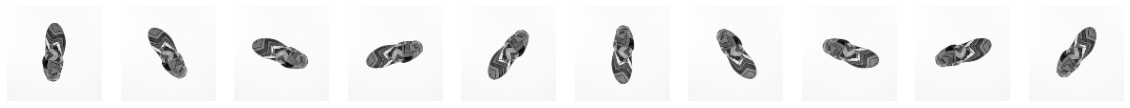

In [9]:
# Select 10 images with a step size of 10
indices = list(range(0, 100, 10))  # This will give [0, 10, 20, ..., 90]
selected_images = [images[i] for i in indices]

# Create a figure with 1 row and 10 columns to display the images
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  # Adjust figsize as needed

# Plot each image on a separate axis
for i, ax in enumerate(axes):
    ax.imshow(selected_images[i], cmap='gray')
    ax.axis('off')  # Turn off axis labels for a cleaner look

In [10]:
# Prepare image shape to present to V4 model
images_model = images[:,:,:,np.newaxis].transpose(0, 3, 1, 2)
images_model.shape

(100, 1, 100, 100)

In [11]:
# Normalize images based on training data mean and std
img_mean = 124.54466
img_std = 70.28

images_model-=img_mean
images_model/=img_std

## Get neural manifold of V4 neurons to images

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model and input to the same device
model = model.to(device)
images_model = torch.from_numpy(images_model)
images_model = images_model.to(device)

# Ensure consistent tensor types (using float for both)
model = model.float()
images_model = images_model.float()

# Pass the input to the model
output = model(images_model, data_key='all_sessions')

In [14]:
# Make into numpy array
output = output.detach().cpu().numpy()
output.shape

(100, 1244)

## Perform analyses on the manifold